In [1]:
# !/usr/local/bin/pip3.9 install seaborn
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from scipy.stats import chi2_contingency, chi2, ttest_ind, ttest_ind_from_stats, norm, binom
np.random.seed(1)

In [4]:
def calculate_n(u, t, k):
    ns = ( ((t + (k - 1)*u)/k) * (1 - (t + (k - 1)*u)/k) ) / ( (t*(1-t) )/k)**2
    return ns


def vertical_plot_lines(x, xal, yal, **kwargs):
    plt.axvline(x.mean(), linestyle = '--', color = kwargs.get("color", "g"), alpha = 0.5)
    tx_mean = "mean: {:.3f}".format(x.mean())
    txkw = dict(size=11, color = kwargs.get("color", "g"), rotation=90)
    plt.text(x.mean()+xal, yal, tx_mean, **txkw)
    
    
def const_line(*args, **kwargs):
    x = np.arange(1, max_k, .01)
    y = x**2
    plt.plot(x, y, color='tomato', alpha=0.5, label='k^2')
    
    
def get_g_test(counts_base, counts_var, visitors_base, visitors_var):
    try:
        p_value = chi2_contingency(
            [[counts_base, counts_var], [visitors_base - counts_base, visitors_var - counts_var]], 
            correction = False, lambda_='log-likelihood'
        )[1]
    except ValueError:
        p_value = [nan]
    return p_value


def get_pval_per_k(k,k_factor, n_trials, p_t_b , p_t_v, p_u, sample_size):
    sample_size_o = int(sample_size*(k**k_factor))
    sample_treated_base_o = np.random.binomial(n=n_trials, p=(p_t_b + (k-1)*p_u)/k, size=sample_size_o)
    sample_treated_variant_o = np.random.binomial(n=n_trials, p=(p_t_v + (k-1)*p_u)/k, size=sample_size_o)
    p_val = get_g_test(counts_base=sample_treated_base_o.sum(), 
           counts_var=sample_treated_variant_o.sum(), 
           visitors_base=sample_size_o,
           visitors_var=sample_size_o)
    
    return p_val  

# Simulations
## Simulate $n'/n_o$ as a function of $k$

In [5]:
max_k = 10
binary_param_vals = [i/10 for i in range(1,10,2)]
k_vals = [i/100 for i in range(100,max_k*100,1)]
results = []
for u,t in product(binary_param_vals, binary_param_vals):
    for k in k_vals:
        n_vals = {
            'P_u': u,
            'P_t': t,
            'k': k,
            'n_tag': calculate_n(u, t, k=k),
            'n': calculate_n(u, t, k=1),
        }
        results.append(n_vals)
            
df = pd.DataFrame(results)
df['n_ratio'] = df['n_tag'] / df['n']
df['S_t'] = np.round( df['P_t'] * (1 - df['P_t']), 3)
df['S_u'] = np.round( df['P_u'] * (1 - df['P_u']), 3)
# df['S_o'] = ( ((df['P_t'] + (k - 1)*df['P_u'])/k) * (1 - (df['P_t'] + (k - 1)*df['P_u'])/k) )
df['n_is_faster'] = (df['n_ratio'] > df['k']**2)

df.head()

,P_u,P_t,k,n_tag,n,n_ratio,S_t,S_u,n_is_faster
0,0.1,0.1,1.00,11.111111,11.111111,1.0000,0.09,0.09,False
1,0.1,0.1,1.01,11.334444,11.111111,1.0201,0.09,0.09,False
2,0.1,0.1,1.02,11.560000,11.111111,1.0404,0.09,0.09,False
3,0.1,0.1,1.03,11.787778,11.111111,1.0609,0.09,0.09,True
4,0.1,0.1,1.04,12.017778,11.111111,1.0816,0.09,0.09,False


In [14]:
g = sns.FacetGrid(data = df.sort_values(by='k'),
                  height=3.5, aspect=1, 
                  col='P_t', row='P_u', 
                 )
g.map(const_line)
g.map(sns.lineplot, 'k', 'n_ratio', color='royalblue', label="n_o/n_t (binary)")
g.add_legend()
g.set(
    xticks=[k for k in range(max_k+1)], 
    xlim=(1,max_k)
)
plt.subplots_adjust(top=0.88) 
g.fig.suptitle("$n_t/n_o$ ratio \nby overtracking factor $k$ and $P_{treated}$, $P_{untreated}$")
plt.savefig('u_t_plot.png')

KeyError: 'P_u'

## Simulate sampled normal distribution as a function of k^factor

In [7]:
### Simulations
sample_size = 1000000
n_trials = 100000
p_u = 0.05
p_t_b = 0.05
p_t_v = 0.05125

sample_untreated = np.random.binomial(n=n_trials, p=p_u, size=sample_size)
sample_treated_base = np.random.binomial(n=n_trials, p=p_t_b, size=sample_size)
sample_treated_variant = np.random.binomial(n=n_trials, p=p_t_v, size=sample_size)

# sample_untreated = np.random.normal(10, 1, size=sample_size)
# sample_treated_base = np.random.normal(10.1, 1, size=sample_size)
# sample_treated_variant = np.random.normal(10.2, 1, size=sample_size)

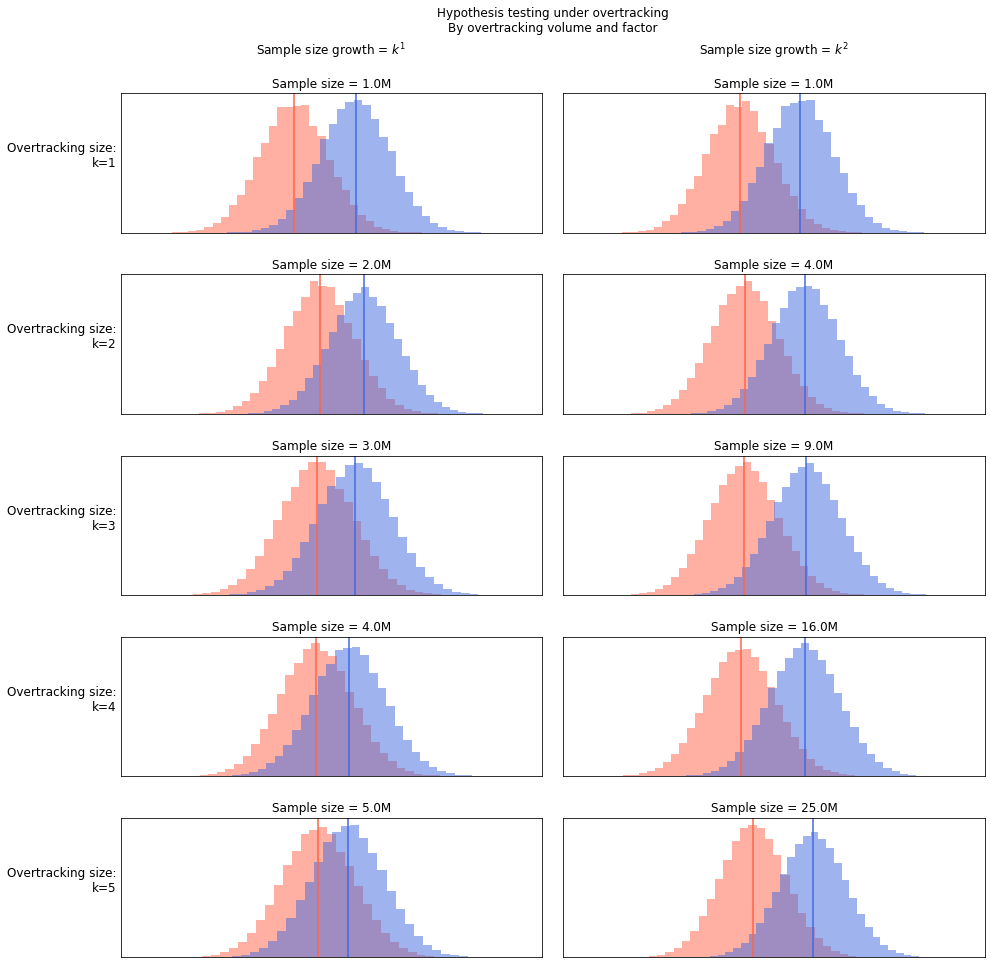

In [8]:
fig, axs = plt.subplots(5,2,figsize=(15,15))
plt.subplots_adjust(
    left=0.1, 
    right=0.9, 
    bottom=0.1,
    top=0.9, 
    wspace=0.05, 
    hspace=0.3
)

np.random.seed(1)
for k_factor in range(1,3):
    for k in range(1,6):
        
        sample_treated_base_o = np.random.binomial(n=n_trials*k**k_factor, p=(p_t_b + (k-1)*p_u)/k, size=sample_size)
        sample_treated_variant_o = np.random.binomial(n=n_trials*k**k_factor, p=(p_t_v + (k-1)*p_u)/k, size=sample_size)
        axs[k-1,k_factor-1].hist(sample_treated_base_o, bins=40, alpha=0.5, color='tomato')
        axs[k-1,k_factor-1].hist(sample_treated_variant_o, bins=40, alpha=0.5, color='royalblue')
        axs[k-1,k_factor-1].axvline(x=sample_treated_base_o.mean(), color='tomato')
        axs[k-1,k_factor-1].axvline(x=sample_treated_variant_o.mean(), color='royalblue')
        if k == 1:
            axs[k-1,k_factor-1].set_title(f'Sample size growth = $k^{k_factor}$\n\nSample size = {((sample_size*(k**k_factor))/1000000)}M') # \nP-value={np.round(pval,4)}
        else:
            axs[k-1,k_factor-1].set_title(f'Sample size = {((sample_size*(k**k_factor))/1000000)}M') # \nP-value={np.round(pval,4)}
        axs[k-1,k_factor-1].set_xticks([])
        axs[k-1,k_factor-1].set_yticks([])
        axs[k-1,0].set_ylabel(f'Overtracking size:\nk={k}', rotation=0, size='large', horizontalalignment='right', y=0.45)

fig.suptitle('Hypothesis testing under overtracking\nBy overtracking volume and factor')
plt.savefig('dist_plot.png')

## Simulate changes in sampled p-values with changes in k^factor

In [9]:
sample_size = 1000
n_trials = 1
p_u = 0.5
p_t_b = 0.5
p_t_v = 0.54

sample_untreated = np.random.binomial(n=n_trials, p=p_u, size=sample_size)
sample_treated_base = np.random.binomial(n=n_trials, p=p_t_b, size=sample_size)
sample_treated_variant = np.random.binomial(n=n_trials, p=p_t_v, size=sample_size)

In [10]:
k_vals = [k/10 for k in range(10,70,1)]
k_factor_vals = [k_factor/10 for k_factor in range(10,40,10)]
bootstraps = [i for i in range(200)]

df = pd.DataFrame([i for i in product(bootstraps,k_factor_vals, k_vals)])
df.columns = ['bootstrap','k_factor','k']
df.tail()

,bootstrap,k_factor,k
35995,199,3.0,6.5
35996,199,3.0,6.6
35997,199,3.0,6.7
35998,199,3.0,6.8
35999,199,3.0,6.9


In [12]:
%timeit df['p_val'] = df.apply(
    lambda x: get_pval_per_k(
        x['k'],
        x['k_factor'], 
        n_trials=n_trials, 
        p_t_b=p_t_b , 
        p_t_v=p_t_v, 
        p_u=p_u, 
        sample_size=sample_size
    ), axis=1)
df.head()

1min 26s ± 2.27 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


,bootstrap,k_factor,k,p_val
0,0,1.0,1.0,1.792188e-01
1,0,1.0,1.1,5.494590e-02
2,0,1.0,1.2,2.884016e-01
3,0,1.0,1.3,1.667765e-02
4,0,1.0,1.4,6.345741e-02
...,...,...,...,...
35995,199,3.0,6.5,1.108951e-06
35996,199,3.0,6.6,3.887865e-04
35997,199,3.0,6.7,1.781290e-08
35998,199,3.0,6.8,6.403581e-07


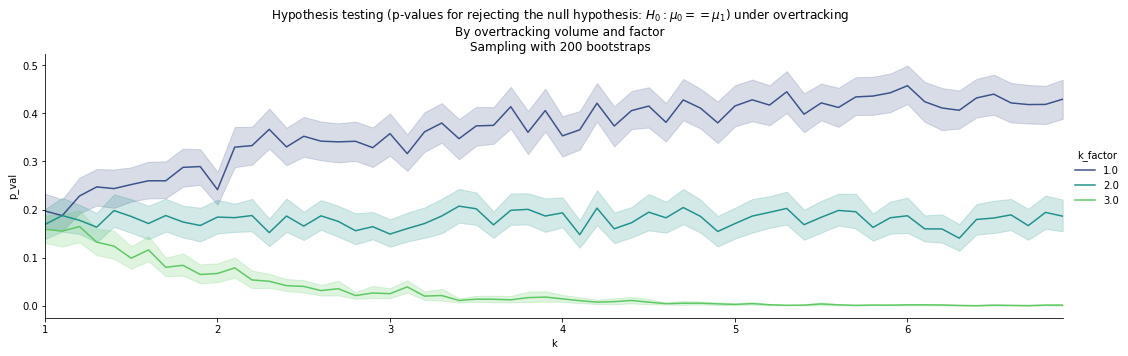

In [13]:
g = sns.FacetGrid(data = df.reset_index(),
                  height=5, aspect=3, 
                  hue='k_factor', palette='viridis'
                 )
# g.map(plt.axhline, y=df.loc[df['k']==1, 'p_val'].mean(), color='gray', ls=':', label='base p-value')
g.map(sns.lineplot, 'k', 'p_val')
g.add_legend()
g.set(
    xlim=(1,max(df['k']))
)
plt.subplots_adjust(top=0.85) 
g.fig.suptitle(f"Hypothesis testing (p-values for rejecting the null hypothesis: $H_0: \mu_0 == \mu_1$) under overtracking\nBy overtracking volume and factor\nSampling with {len(bootstraps)} bootstraps")
plt.savefig('pval_plot.png')